# Discrete Task:
- Load data

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
from discrete_helper_functions import *
from comparison_helper_functions import *

# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./train_data.npy')
y = np.load('./train_labels.npy')
X_test = np.load('./test_data.npy')

train_data = pd.read_pickle('./train_data_df.pkl')

# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))

Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  219


## Discrete Methods

### Piecewise Aggregate Approximation

In [3]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X1_scaled = ss.fit_transform(X1)

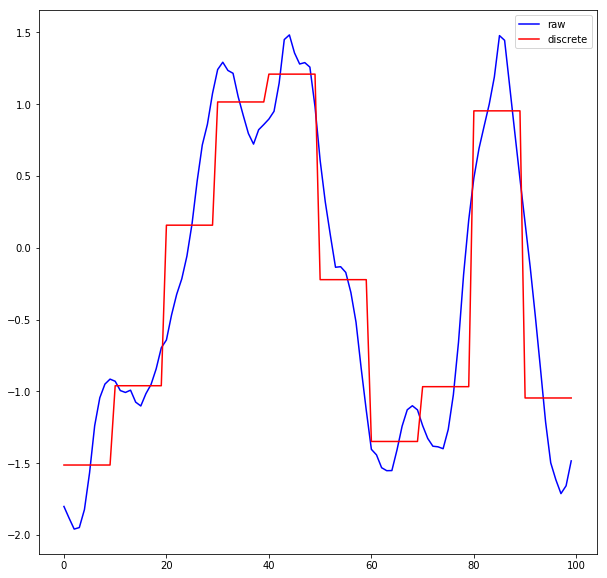

In [4]:
from tslearn.piecewise import PiecewiseAggregateApproximation

raw_data = X1_scaled[:100, 0]

n_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(raw_data))

plt.figure(figsize = (10,10))
plt.plot(raw_data, color = 'b', label = 'raw')
plt.plot(paa_dataset_inv[0], color = 'r', label = 'discrete')
plt.legend()

#### Sybmolic Aggregate Approximation

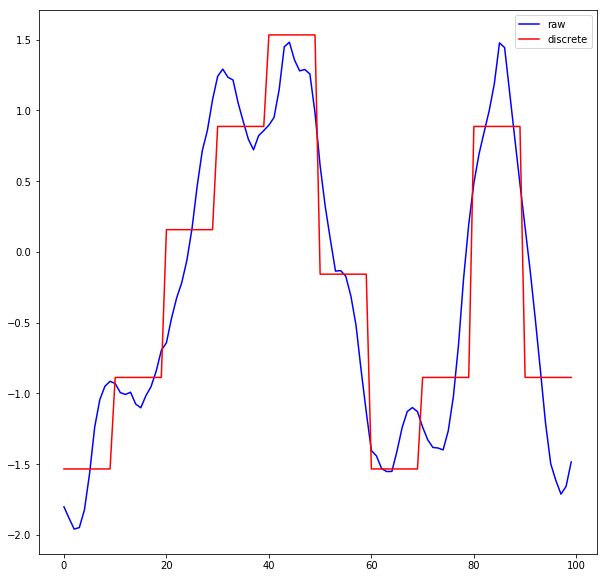

In [5]:
from tslearn.piecewise import SymbolicAggregateApproximation

n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=n_sax_symbols)
sax_dataset = sax.fit_transform(raw_data)
sax_dataset_inv = sax.inverse_transform(sax_dataset)

plt.figure(figsize = (10,10))
plt.plot(raw_data, color = 'b', label = 'raw')
plt.plot(sax_dataset_inv[0], color = 'r', label = 'discrete')
plt.legend()

In [3]:
# Discretise train and test signal
train_sax=sax_via_window(X1[:, 0], 51, 8, alphabet_size=3,
               nr_strategy='none', z_threshold=0.01)
test_sax = sax_via_window(X2[:,0], 51, 8, alphabet_size=3,
                         nr_strategy='none')

In [4]:
# Extract ngram probabilities and training profile based on most frequent ngrams
train_probs = extract_ngram_probs(train_sax)

labels = np.array(y2, copy=True)
labels[labels==-999] = 0

train_prof = extract_train_prof(train_probs, thres=1)

# raise an alarm for encountered ngrams in the test signal, not present in the 
# training profile
alarm_regions = extract_alarm_regions(test_sax, train_prof)

In [5]:
# Compute score S
gamma=0.5

predicted_labels = np.zeros_like(labels)
predicted_labels[alarm_regions] = 1

sttd = compute_sttd(labels, predicted_labels)
cm = estimate_confusion_matrix(labels, predicted_labels)
scm = compute_scm(cm)
s = compute_s(labels, predicted_labels,gamma)

print(cm.shape)
print(sttd, scm)
print(s)

(2, 2)
0.41799333580155495 0.5877068811562502
0.5028501084789025


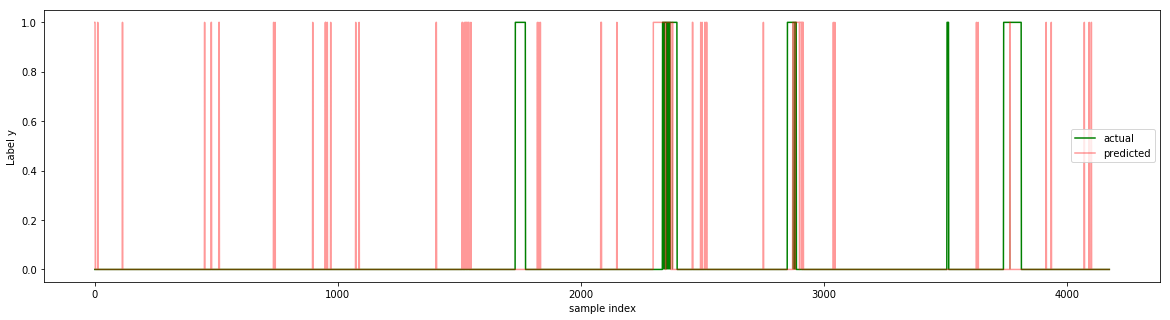

In [6]:
plot(labels, predicted_labels)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJIAAAFACAYAAADnI1acAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xu8XXV95//3JzkJIRdIQgIKAZJWLCACQqAg6Ih4CZWKY2GU0YrWwkNbnXZap6X+qlbGGcd2HmjpYGlarE5LZRC18LAUBbkpCBIUUe6BBIgh95ALuSef3x97n5N99ln77LX2Wt91fT194M7ee+29vuv7/a7vWuuz1/dzzN0FAAAAAAAA9DOh6AIAAAAAAACgGggkAQAAAAAAIBYCSQAAAAAAAIiFQBIAAAAAAABiIZAEAAAAAACAWAgkAQAAAAAAIBYCSQAAAAAAAIiFQBIAAAAAAABiIZAEAAAAAACAWIaKLkBSc+bM8fnz5xddDAAAAAAAgNp46KGH1rn73H7LVS6QNH/+fC1ZsqToYgAAAAAAANSGmT0XZzmmtgEAAAAAACAWAkkAAAAAAACIhUASAAAAAAAAYiGQBAAAAAAAgFgIJAEAAAAAACAWAkkAAAAAAACIhUASAAAAAAAAYgkWSDKzr5jZGjP7RY/3zcyuMrOlZvaImZ0SqiwAAAAAAABIL+QdSV+VtGic98+TdEz7v8sk/W3AsgAAAAAAACCloVBf7O73mNn8cRa5QNL/dXeXdL+ZzTSzV7r7i6HKVCpPPSXNmSPNni2tXi3NmiVNnhxufStWSPPmhfv+pli5UnrFK6QJXTHYbdukNWuk+fOjP7dhg7RrV+uzdbNypTR9urRvnzRzZtGlGW3NmlaZ4u5be/dKjz8uHXWUtH27dNhhrddXr27tq5Mm5VPWbdukHTta60Q8L78srV3bex/Mcj3r1klHHNF63Lat9frkya02O/RQac8eacoUaerUsGXJyNZdW/XNx76pXXt39V32qIOP0ttf9fZ4X+zeGh+mTpUmTmzV3StfmbK0FbJmjbR1q/QrvzLY5zdskA44QJo2LdtyDWr3bmnZstZY34O763vPfE+bdm6SJE3Y69o30UYvM2GCthwxV1PXbdLLh86UbP/7b/3Vt2r+zPnJy7Zvn7R8ees8p9d4v3q1dOCBre045JDW84kTpc2bW/3ywAOTr7cK9u2TVq2SDj88yNfv2rtL33j0G9q2e9uo1w9c95KmvPSyfOIE2T7Xgjmv0qmHn9p6c8sWacaM1nmRuzR3brDy9bR3b2sfnTSpdQ4zZUq+60cmntnwjO5YdoemT56ui15zkYYmBLu03c9d+uUvW+do27e3xpOA/u2pf9PKLSvHvD5p6zZJpt3T441dJxx6gs488syMS9dh+/bWcX7OnP2v7dolbdy4/3y6CHv2tM7XOq/Bhss6a1brWJD3+FMTOextPR0h6YWO5yvar40JJJnZZWrdtaSjjjoql8IFd9ddrZ3qHe+QbrqpdVHyjneEWdeTT0p33y296U3Sq18dZh1NsG6d9J3vSCecIL3+9aPfu/tu6YUXpPe8Rzr44LGf/da3Widzl12WT1nzsnZtq06GlWn79uyR/vVfWweH88+P95l775WeeEK6777W80suaT3edJN05JHSeeflU9brrmudqJSpPsvujjukF1+U/vN/bl0UhPL977cuyg47rHXy0a3z9Yq03w2P3qAP3/zhWMuaTFs/uVVTJ8UIkj3yiPTAA6Nfu+ii1olbE/zrv7Ye3/te6aCDkn/+xhtbj2XpR888I91zz7iLrNq6St+88zN9v+rpQ6Rj1kv3HSk92nF98YGTPqCvvetrycv2/PPS7bdLJ58snX762Pd37WqN48Muu2z081/9Vencc5OvtwoeeED6+c+ld7979AVeRr7/7Pf1/m+/f8zrly4Z/Xz65Gk69e1X9v6ivPv58PFeagW73z92G1B+l3//ct34WGusPOKgI/TGo98YfqU//7l0//37nwfsuxu3b9T5X48+hx3ex/5+YbzvOvKgI/X8f30+o5JFuPHGVoCmsz5uu60VdPvQh8L+GDueu+6Snn22tY8P/8D3zW+2fgg8/njpsceadW6SoSIDSRbxmkct6O6LJS2WpIULF0YuUzlz5rR+Ddm7t/V87dpw69qyZfQjBrNjR+vxpZfGvjfcfr1+qR3nF9xKG66TMvL2UJFk39qwYfTz4f1TktavT1+mXrrL6vUY5nI1HLwJva8Nr2fNmuj3t24Nu/4Adu7ZKUn6yWU/0aHTDu253OKHFuuKe67Qnn174n3x5s0RK9s5SBGrbVf/O70qYXg8/K3f6nn3xrrVP9d161uBpJNWSV884nf0uaVf0R0LWu8fvEP63LZf1+ffcKkmrF2nPa85TrtOb92l8oZ/fEOsu+Ii7Wn3yV77X79xYePGwdZbBcPbFuh4vXNva5++9X236oRDTxh5fd2X/qd27N2pu5ffre17tuv6eRt15fveJz39tPTjH7fuHluxIkiZYuk83m/b1ns5lNrw8UvS4ONHUlHHtkCGt+l/vPl/6JKTLhn13tR//GdJ0mc+1D8Ievn3L9dtz9yWfQE7bd8+9rV+10d5WLeu9bh79/7Xhvf54XGgiecmGSgykLRC0pEdz+dJGnvfXl1NncqBCwBQGofPOFyHTe99+/nBUyLutkTzTJvWM5C0b+qB2taeWbZrojR98nTtmaCR1ybvlQ4YmqJDph4in7JHNm2udNARkqRJEwv6tRqZOGz6YTqi3ZaStPOAgzS0Z7smTRzS7r0TtWPIWn3ngANaCxR1dwJQQbOmzBq1f0mST5kpM9OsrtejTJ8U8E5tNFbIZNv93CzpA+2/3naGpE2NyY8EAAAAAABQQcHuSDKzr0t6k6Q5ZrZC0mckTZIkd79G0i2SfkPSUknbJH0oVFmA3DAlCUDFePSs8t7LM86hh+6+FNm32v3H5WNyHNC3qqd3m3mrrb1n3oqApUJTdI4xdRw/xjs+t8bQqEwxyb8LGETIv9p2cZ/3XdLvh1o/AAAACjTedQvXNLXHhSsQkCs64zCQkyKntgEAgJIwG/+MNMkvn0CU8cIK9K9qG6/9It/pM94A2K/f8Tn054EoBJIAAAAAAAAQC4EkAEB95JUjoUa5GJLmlWC6SkPF6CfdfSmqrwy/Nt57qI5ebeYj+ZFaS4xZrkZjKIrTOebUcfwY7/hMfkMUjUBSUbjFEAAA1Bgpkpqtjhf2QFmwd6FoBJIAAEDfHDXkWEAS3u4ucS926F/VNl77mTr6wfBytDcQW9occuSgQwgEkgAAAAAAABALgaQiMVcVAFAw8iwgK2P7ko/9HdzVPv+JyJFE36qc8XO4dP5HjiRkr7Nf1XH8GP/4TH5DFItAEgAAADI3bpChhhd96EYbA6EwhqJoBJIAAEDfHDXkWICkxLltYudIon9V2njtF/kOOZKA2NLmkCMHHUIgkAQAALLHr6XIC30NAIBcEUgCssTJLFAs9sHEkt4eT54F9BKnL43Xf+hb1dOrzVze7g/eTotF2yJ7nf2qjuNHlvsN+yCyRiCpKNxiCAAokX5TixLfGs9xrtGiEiy7db4/+r1UUy/oa4Ubr/1oHSCdqONzksAZU4cRAoEkAAAAAAAAxEIgCQAAZI/b6DGOTHsHfa20mE4DhMGehaIRSCoSB1cAQMGS5pXgwrChBsh/FPUJH/6uiO+jb1VPrzbrnNoYNc0RyEJnv6rj+NFvv0myzeyDyBqBJAAA0DdHTeIcC+Stqack7ZrgIidVDg/6WuGic7gMv9eRH4u2AhJLlUMug88DUQgkAQAAAAAAIBYCSQAAIHs1nGaA7GQ6zYK+BqBpGPdQMAJJQJYY1AFUTNK8EuRZQC/dfSm6r/ioh/7Lo8x6tllHHixXjHGG8ycMwN1HplXWcfzot98k2eY65pBCsQgkAQCAvjlqEudYICcDfNyno6TK4UFfK1xU+w1f5NI6CKkJ+X9S5ZDL4PNAFAJJAAAAAAAAiIVAEgAAyB630WMc5EhqBqbTAGHUcSofqoVAEoB6qtLJa5XKWnbUZWJJT0a5MGyoGO3e3Zei+pZ35M3p9R6qo1ebuXy8dFhAJlwdOZJqOH70PT4n2GQCT8gagaSiNGA+LwCgOvrlmUicY4HjXKO5JQsgpMrhQV8rXFT7dV64jvyLtkLGGpEjKeU2NqGOkD8CSQAAAAAAAIiFQBIAAMheDacZIEvkSGoCH3mkjYBMsUuhYASSisSJDwCgYEnzSnBBiF7G9qUefcU9st/Rt6qnZ5t5wutczokxAPeOHEk1HD/6HZ+TbHMdc0ihWASSAABA3xw1iXMskJOhnhK0a5ILl1Q5POhrhYtuPy5cEV4T8v+kyiGXweeBKASSAAAAAAAAEAuBJAAAkD1uo0de6GslRtsAIdRxKh+qhUASkCVOZoFisQ8mlvRklDwL6CVOXxpeJmpZ+lb19Goz1+g8WLQtQnB15EiqYR/rN6Ym2WICT8gagaSiNGA+LwCgOvrlmUicY4HjXKO5xl64+DhdIlUOD/pa4cjBgqI0IkdSym1sQh0hfwSSAAAAAAAAEAuBJAAAkL0aTjNAdjLtHfS10mI6DRAGexaKRiCpSO6c/AChVGnfqlJZUTtJ80pwYdhQMfpJd1+K+oQPf1fE99G3qqdXm3VPbaRtEYJ7R46kGvax/sfn+NtcaA4pznNriUASAADom+MkcY4FcjLUU5J2TXDxkCqHB32tcFHt19n6I/mxaCtkrAn5f9LmICOHGUIgkAQAAAAAAIBYCCQBAIDscSs7xpHpNBT6WnnRNEAg7FwoFoEkIEuczAKomKQX9IXmWUCpdfel6L7lox5GvROqb9Fng4lsM29lSOqs975tSxthAK6OHEk17EP9js9JtrmOOaRQLAJJAACgb56JxDkWGpC3An34uE9HSZXDg75WuKj248IVeWhEjqSU29iEOkL+ggaSzGyRmT1pZkvN7PKI948yszvN7Kdm9oiZ/UbI8gAAAAAAAGBwwQJJZjZR0tWSzpN0vKSLzez4rsX+XNIN7v46Se+V9OVQ5QEAADmq4TQDZIccSc3AXUlAGHWcyodqCXlH0umSlrr7s+6+S9L1ki7oWsYlHdT+98GSVgYsD4AmqdIBtkplLTvqMrGkJ6NcGDZUjH7S3Zei+srwMtHZk+hbVdOrzdydXMAIzr0jR1INO1yWwSICT8jaUMDvPkLSCx3PV0j69a5l/kLS98zs45KmSXpLwPKUC3NVAQAl0i9HTeIcCxznGs0tWRwhVQ4P+lrhotqv88Le9y+YT4HQGE3I/5Mqh1wGnweihLwjKarHdp9TXCzpq+4+T9JvSPonMxtTJjO7zMyWmNmStWvXBigqAAAAAAAA+gkZSFoh6ciO5/M0durahyXdIEnu/iNJUyTN6f4id1/s7gvdfeHcuXMDFRcAAGSG2+gxLnIkNQEtAwD1FDKQ9KCkY8xsgZlNViuZ9s1dyzwv6VxJMrPj1AokNeeWI3dOfgAAhUqaV4I8C+hlbF/q0VfcI/tRsL5Fnw0mss0i8mD1HWdoIwzA1ZEjqYZ9qN9+k+T4XWgOqRq2DQIGktx9j6SPSfqupMfV+utsj5rZFWb2zvZifyzpUjP7maSvS/qg13EUAACg5PrlmUicY6EBeSsaKUG7JjmlS5XDg75WuOj245Qe4TUiR1LKbWxCHSF/IZNty91vkXRL12uf7vj3Y5LOClkGAAAAAAAAZCNoIAmolTi/rHJDXfkkaZPuZTuf59G29J/0iq7Dotc/gKQ3Ase+Pb6CdYF00t5UPvDUi7R9rQl9NdA29m+z9jS3stVx2cqDgXT2q9ymbuXYd8bbb5iWjqKFzJEEAAAAjPB2fshC83UgOFd0Hiwga03+0/bsYSgSgaSiMFe1emizakrSbuMtm0f708eqr8Jt2O9kPHGOhQrXBdJzjf3F3Ie7RETfSJXDI21fa0JfDbyNlcvBUrXyoqfc+14BfSdtsKzJwTaEQyAJAAAAAAAAsRBIKlL79m5UBG1VLcPtlSZHUtz30hqkrCinCrZhsDwLFawLjCNGeybJnxW15MBTociR1F+oHEl9vnf4/dLVcBPavAE6R5LcplLmmSNpnD0naSkKnU7M/lZLBJIAAACQuchg0cg/uLCos6ipjUAIjZ62xTiKAhFIAuJiPn01kSMJeapwG/bLM5H4ZL3CdYFxJGnXBBc5hV4MNqGvhs6RFNF+na0/Xn6sQpSlHEitETmSUq6zcjnMUAkEkgAAQPb4pRQAAKCWhoouAFAZcS6KuHAqnzQ5kjqf59G29J/qq2AbJs0rwXQV9JKkL0X1o2B9q1+5KrjfJhYqR1JUmw2yrrzboAlt3gCdY05ux6Y8cyRlmLsztxxSaAzuSAIAAEDmeqTUHvWAmhr1B2VobITT5BxJ/LCDIhFIAuJifnE1kSMJeapwG/Y7GU+cY6HCdYGMdN/kOc6ihebwaEJfDZ0jKeL791/klrB+m9DmDdGIHEkp96EmB9sQDoEkAACQPW6jR17oawAA5IpAEhBXFieqnOzmZ7iu0+RIivteWoOUFdGKrsOi1z+ApLfGk2ehoWK0e5K+FJkjqai+1YQ+HSpHUp/vHZXDpkz1XKayYGCd40hu/SvPHEnjjKmJj91Mg0PGCCQBAAAgcz0TajuXNHXXauf9z4BQGj1ti10LBSKQVBTmZlcPbVZN5EhCnirchv3yTCQ+Wa9wXSA9t3GucSL6RqEXg03oq6FzJEW0X2eOpJG+UJa6Lks5kFojciSlXGehOehQWwSSAABA9pg6gnHRP5qAVgYCYedCwQgkFWnUn0ZF6dFW1VSFHEl5rgNhVbANk+aVYFISeondl3osF6xv9StXBffbxELlSIpqs0HaN+82aEKbN8CoHFx5HZvyzJGU4boKzVHG/lZLBJIAAAAQQFSQof3AhUW9daZIIviMgJqcI4kfdlLiOJQKgSQgLuYXVxM5kpCnCrdhv5PxxDkWKlwXGEeCdk0SLCo0h0cT+mroHEmR378/R1LpNKHNG6IROZJS7kNNDraNi3EgFQJJAAAge/zSB4A7JoAguBsJRSOQBMQV56KIPAzlkyZHUmceM3IkVUPRdVj0+geQ9GSUKUnoJe2FTWF9qwl9OlSOpATfW6qxo0xlwcA6x5zc+leeOZIyDBYReIrAOJAKgSQAAADkwtUK0HNRU28u77iwp60RTpOnbbFnoUgEkorCnMzqoc2qiRxJyFOF27BfnonEJ+sVrguk5xr7C7gPd4mIvlHoxWAT+mroHElVu5hvQps3RCNyJKVcZ6E56FBbBJIAAED2uGUc48i0d9DXSos7z4Aw2LNQNAJJRerMv4Lyo62qZZDcRuMtG7L988zDhLAq2IZJ80pwYdhQMfpJ7L7UY7nC+lYF99vEQuVIStBmpRo7mtDmDdA55uTWv/LMkZThugrNIVWG/a0MZagZAkkAAADIXNRp+8hrnNTXWtTURiCEyk2rzBT7WCoch1IhkATExfziaiJHEvJU4TbsdzKeOMdChesC40jSrglO0gvN4dGEvho6R1LE93e2/nj5sQpRlnIgtUbkSEoZLGt2sG0cjAOpEEgCAADZ45c+jIO7VRqCZgYCYedCsYaKLgBQGXEuirhwKp80OZI6n+fRtvSf6qtgGya9oM8tzwIqJ21wKFjf6ve9TejToXIkJciHMm775t0GTWjzBugccwrNARRqVRkGiwjeR2AcSIU7kgAAAJC56AsXH/WAuuIPyiAfTZ62xQ87KBKBJCAu5tFWEzmSkKcKt2G/PBOJT9YrXBfISPdNnuMsWujFYBP6augcSRHtV+o7IJrQ5g3RiBxJKddZaA461BaBJAAAkD1+KcU4Mg0y0NdKq9TBJKDCuBsJRSOQBMSVxYDNoJ+f4bpOkyMp7ntpDVJWRCu6Dote/wCSnoxyYdhQMfpJ2gubwvpWBffbxELlSErQZqUaO5rQ5g3QOebk1r/yzJGU4brqmEMKxSKQBAAAgMxFXdi5t3LncKlRb612LroUaIIm50gCikQgqSjMVa0e2qyayJGEPFW4DfudjCfOsVDhukB6buPEESL6RqE5PJrQV0PnSIr4/lF/USvo2gfQhDZviEbkSEoZLCPYhhAIJAEAgOxxezvGRf9oAloZAOqJQFKRnD+NWim0VTVVIUdSnutAWBVsw6STjEjwiV5i96UefShY3+r+3n7P6yhUjqSo7x2kffNugya0eQOMuuuthjmAspwEXOiE4jLsb2UoQ80QSAIAAEAAvU/cCUjWn4880tYIp8nTtti3UuI4lAqBJCAu5tNXEzmSkKcKt2G/PBOJT9YrXBfIRpJgUaEXg03oq6FzJEW2n4/zXsGa0OYN0YgcSSnXWWgOujKjXlIhkAQAALLHL30AuGMCCIK7kVC0oaILAFRGnIuifstwYZW/NDmSOp+TI6kaiq7Dotc/gKRTjDh5RS9pp6vl1rfIkZTd1yZos1KNHU1o8wboHHMKGz+Crop+GhT1m0rQO5LMbJGZPWlmS83s8h7L/Ccze8zMHjWzfwlZHgAAABTH239opFRBBWTO5SMXwbQ1Qirl1MmcsGehSMHuSDKziZKulvRWSSskPWhmN7v7Yx3LHCPpzySd5e4bzezQUOUpHeZkVg9tVk1ZtRs5khBHjdswcY6FGtdFYyVoU9fYAIIPfzziewrN4dGEvho6R9I431/KC/0mtHlDNCJHUsp9qJT7ICov5B1Jp0ta6u7PuvsuSddLuqBrmUslXe3uGyXJ3dcELA8AAMgLt4xjHJn2DvpaaTE1BwiDPQtFCxlIOkLSCx3PV7Rf6/RqSa82s3vN7H4zWxT1RWZ2mZktMbMla9euDVTcArRv7wYQQJX2rSqVFbWTdNoJF4YNFaPdx9yBJI35HdyHvyvi++hb1dOrzTrvSBt57Gx32hoZ6Bxz6jh+9D0+J81xWFS+zzK0TRnKUDMhA0m9/w7ofkOSjpH0JkkXS/oHM5s55kPui919obsvnDt3buYFBQAAGWPqCMp64l7WctUMtYw8MG0LKEbIQNIKSUd2PJ8naWXEMje5+253XybpSbUCSwAAICdxTsQ5Wccg4gYT6F/V1q/9xuTHItCMjBSaXy0nabexCXWE/IUMJD0o6RgzW2BmkyW9V9LNXcv8q6RzJMnM5qg11e3ZgGUCAAB54K4PjIO/5AUAKXCMRcGCBZLcfY+kj0n6rqTHJd3g7o+a2RVm9s72Yt+VtN7MHpN0p6T/5u7rQ5UJCI5Bvdq62488ZmiApDkTCACgl+6+5PKI+1R81EP38kEwjgcT2WbDx86I/tAzRxJthAF0jjmFHZsC9t1+x+fEOQ45fo/GuJPKUMgvd/dbJN3S9dqnO/7tkv6o/R8AAKgLbqVHWc/RuXjIBRetyAPTYoFihJzaBgAAKiBO/oTEORa4WK+fAYKD3uPfY786xcUgfa1wsduPHEnIWBPy/6QNlhFsQwgEkgAAAJAr7lZphjr+SXagDBhDUbSgU9sAdOGEKj9VqusqlbXsqMvEEudYoI6TqUt9xdiO7r4UlSNpeJmob6NvVU+vNmvlQxp5sn/ZXjmSgAF0jjl1HD/6Hp8TbrK7K/jNSYHbYffu3VqxYoV27NgR7wOvepW0b5/04ovS6tWt104+ufU4caI0b560bp20cWOYApfYlClTNG/ePE2aNGmgz/cNJJnZxyRd5+7Nq92QGnAbJgCgwTjONV79LuuQBHdMIA9M22qWFStWaMaMGZo/f368aY0bNkh790qzZklD7dDH2rWtx6Ehac8eaeZMacBgSlW5u9avX68VK1ZowYIFA31HnKltr5D0oJndYGaLrAkTUQEAaJA4J+KJT9Zr+Osw4vN2d4nbC7gYrLZx2886+gE5kpCxJlyapt3GOtXRjh07dMghh9Rqm4pgZjrkkEPi39kVoW8gyd3/XNIxkq6V9EFJT5vZ/zSzXx14rQAAAGgwAo1NQCsDgTR45yKIlI209Rgr2ba3Jp2uav+3R9IsSTea2V+mWnvTdc4VBwCgAEnzSjBdBb2M7UtjcyTJJblH9rtgfat7XZx7ZSayzbyVH2lsbxgnRxJtggF0jiOFHZsC9t1+x+fEOQ5rWEcoTt9Akpn9FzN7SNJfSrpX0mvd/aOSTpX0W4HLBwAAqohfDBuvjslvkQTtj/CYFosyu+uuu3Tfffel+o7p06dnVJpsxfmrbXMkvdvdn+t80d33mdn5YYoFAADyEuf25sS3QBNEgBLkSCLwWGmx248cSchYE8aOtMEygm3FueuuuzR9+nS9/vWvL7oomYuTI+nT3UGkjvcez75IAAAAAKqPgDIQAtPMi/Wud71Lp556ql7zmtdo8eLFkqRbb71Vp5xyik466SSde+65Wr58ua655hp98Ytf1Mknn6wf/OAH+uAHP6gbb7xx5HuG7zbaunWrzj33XJ1yyil67Wtfq5tuuqmQ7Uoizh1JAOLq9ws8v9CXGzkbqo82SyxxjgXquL/OOmpQfUX1pe7fwYeXiVo2t77VoDYJrVebuTryYHnHsr1yJAED6BxH6nhs6nd8TrrFdaujP7z1D/XwqofHX2jPntZ4MzS0/07I3btbj2Zj3jv5FSfrS4u+1HfdX/nKVzR79mxt375dp512mi644AJdeumluueee7RgwQJt2LBBs2fP1kc+8hFNnz5dn/jEJyRJ1157beT3TZkyRd/+9rd10EEHad26dTrjjDP0zne+s9R33BFIKkqJOwUAAKlxnGs8fjEHEBrTtlCEq666St/+9rclSS+88IIWL16sN77xjVqwYIEkafbs2Ym+z931yU9+Uvfcc48mTJigX/7yl1q9erVe8YpXZF72rBBIAgCg4eKciCc+Wa/ZL59QouCgdz1Kko/z8VQXg/S1wsVuP3IkIWNlvmMjK2m3sa51FOfOIW3YIO3dK82a1brzSJLWrm09Dg217liaOVOaNCn2eu+66y7dfvvt+tGPfqSpU6fqTW96k0466SQ9+eSTfT87NDSkffv2SWoFj3bt2iVJuu6667R27Vo99NBDmjRpkubPn68dO3bELlMReuZIMrMtZra5/d+WjudbzGxznoUEAABAfRC4m2KMAAAgAElEQVT6aQbuSgPCYM8qzqZNmzRr1ixNnTpVTzzxhO6//37t3LlTd999t5YtWyZJ2rBhgyRpxowZ2rJly8hn58+fr4ceekiSdNNNN2l3e5rdpk2bdOihh2rSpEm688479dxzkSmqS6VnIMndZ7j7Qe3/ZnQ8n+HuB+VZyNrqnCsOIFtV2reqVFbUTtKcCVwYNlSMftLdl1xROZLU8/yHvlU9vdrMI95zkSMJ2eocc+o4fvQ/Ppfw+B1V5jLs7xmWYdGiRdqzZ49OPPFEfepTn9IZZ5yhuXPnavHixXr3u9+tk046Se95z3skSb/5m7+pb3/72yPJti+99FLdfffdOv300/XAAw9o2rRpkqT3ve99WrJkiRYuXKjrrrtOxx57bGblDSXW1DYzO1vSMe7+j2Y2R9IMd18WtmgAAKCyanorPRIow8VDlLKWq2aoZeSBHEnI2wEHHKB///d/j3zvvPPOG/X81a9+tR555JFRr91///0j//785z8vSZozZ45+9KMfRX7n1q1b0xQ3mJ53JA0zs89I+lNJf9Z+abKkfw5ZKAAAkJ84+RMS51jgYh3qHUzo/mW8rjk8mqJn+w3fgGQjC45+BFJqwtgRHSyLf4wl2IYQ+gaSJP1HSe+U9LIkuftKSTNCFgqBNGCgBQAAAAAA4cQJJO3y1gRNlyQzmxa2SAiGX4fDo46rrbv9yGOGBkiaMyFpTqVGamgdReXEGfsTlo96GPVOqHpraHvkIbLNhi8bunNmdR5To463QEKdY05hx6aA6+13fE6c45D9bDRytqUSJ5B0g5n9naSZZnappNsl/X3YYgEAgErjLliU9dyci4Zc1DH5McqHaVtAMfom23b3/21mb5W0WdKrJX3a3W8LXjIAAJCLOCfiiU/WuVivnwGCg97z3105ktJcDNLXCter/cYEk8iRhIw1IkdSxDYmubuoCXWE/MX6q22Sfi7pQLXOAX4erjgIikEEAAAAAACkEOevtv2upB9LerekCyXdb2a/E7pgCIBf7IpHG+SnSnVdpbKWHXWZWOIcC2mmqzSxfeqyzTG2o7svReVIGl4m6tuYClU9vdqslQ8pYllykiBDnWNOHcePrHMa5VJH7NuJTZ8+XZK0cuVKXXjhheMu+6UvfUnbtm1L9P133XWXzj///IHL10ucHEn/TdLr3P2D7n6JpFMl/WnmJWka7g4CANQZx7nG43Ki2ep4YY/yIUcSymjv3r2JP3P44YfrxhtvHHeZQQJJocQJJK2QtKXj+RZJL4QpDgAAyFuc/AmJcyzwq2Sjebu79O4FXTmSCDxWWq/2865HciQha00YO9IGywi2ZWv58uU69thjdckll+jEE0/UhRdeqG3btmn+/Pm64oordPbZZ+sb3/iGnnnmGS1atEinnnqq3vCGN+iJJ56QJC1btkxnnnmmTjvtNH3qU58a9b0nnHCCpFYg6hOf+IRe+9rX6sQTT9Tf/M3f6KqrrtLKlSt1zjnn6JxzzpEkfe9739OZZ56pU045RRdddJG2bt0qSbr11lt17LHH6uyzz9a3vvWtIPXQM0eSmf1R+5+/lPSAmd2k1nHgArWmuqFqGjDQAgAAAABq7r77pPXrx19myxZp3z5p2jRpqB362LSp9ThhQuu9qVOlSZNarx1yiPT61/dd9ZNPPqlrr71WZ511ln7nd35HX/7ylyVJU6ZM0Q9/+ENJ0rnnnqtrrrlGxxxzjB544AH93u/9nu644w79wR/8gT760Y/qAx/4gK6++urI71+8eLGWLVumn/70pxoaGtKGDRs0e/ZsXXnllbrzzjs1Z84crVu3Tp/73Od0++23a9q0afrCF76gK6+8Un/yJ3+iSy+9VHfccYde9apX6T3veU//uhzAeMm2Z7Qfn2n/N+ymICVpIvd8f7Hl12GgWtwJACO4pNNPss7ZgPoY25fG5khqveyR/ShY3+r+XvpwZiLbrCsP1nC/cB8nRxJtggF0jjmFHZsCrrff8bkyx+8a7t9HHnmkzjrrLEnS+9//fl111VWSNBK02bp1q+677z5ddNFFI5/ZuXOnJOnee+/VN7/5TUnSb//2b+tP/3Rs1qDbb79dH/nIRzTUDn7Nnj17zDL333+/HnvssZFy7Nq1S2eeeaaeeOIJLViwQMccc8xI+RYvXpzJdnfqGUhy989mvjYAANAMBEEbj6Bj09H+CI9pWw0W484hbdgg7d0rzZy5/66jtWtbjxMntt47+GBp8uREq+6eUjn8fNq0aZKkffv2aebMmXr44Ydjfb6bu8da5q1vfau+/vWvj3r94YcfzmXKZ5y/2jbXzP7KzG4xszuG/wteMgAAkIs4J+KJT9YJIkDxQwlcDFZb7/bz0e+RIwkZa0SOpIhtTHI3UhPqKG/PP/+8fvSjH0mSvv71r+vss88e9f5BBx2kBQsW6Bvf+IakVtDnZz/7mSTprLPO0vXXXy9Juu666yK//21ve5uuueYa7dmzR5K0YcMGSdKMGTO0ZUsrffUZZ5yhe++9V0uXLpUkbdu2TU899ZSOPfZYLVu2TM8888xI+UKIk2z7OklPSFog6bOSlkt6MEhpEBaDCAAAAAAAAzvuuOP0ta99TSeeeKI2bNigj370o2OWue6663TttdfqpJNO0mte8xrddFMrQ9Bf//Vf6+qrr9Zpp52mTcP5mrr87u/+ro466iideOKJOumkk/Qv//IvkqTLLrtM5513ns455xzNnTtXX/3qV3XxxRfrxBNP1BlnnKEnnnhCU6ZM0eLFi/WOd7xDZ599to4++uggdTBejqRhh7j7tWb2B+5+t6S7zezuIKVBWPw6HF6/OqYNyo2cDdVXdJsVvf4BJJ1+lOpPelewfgbSuZ1N2WZF96Xun7B8JH9ORI6kvKZCNahNQuvVZi4f09aucXIkAQPoHHNyGz9y1O/4nHSL61hHRZkwYYKuueaaUa8tX7581PMFCxbo1ltvHfPZBQsWjNzNJEmXX365JGn+/Pn6xS9+IUkaGhrSlVdeqSuvvHLUZz/+8Y/r4x//+MjzN7/5zXrwwbH3+CxatGjkr8SFEieQtLv9+KKZvUPSSknzwhWpIbg7CABQZxznGo+LFgChMS0WKEacQNLnzOxgSX8s6W8kHSTpD4OWCgAA5CZO/oTEORa446B+EvQB73qUJLex7+//6hQXg/S1wvVqP3dyJCGsJuT/iQqWJRn1CLZlq/POoSbrG0hy9++0/7lJ0jmSZGYEkqqoAQMtAAAAAKCe4vxFM/SX9i+rxkm2HeWPUq0VLe75/orGL3Zokir1915lrdI2oLKSTj/iT7o3VIx27+5LrogcScPfFfF99K3q6dVmrq7cSMPLkiMJGeocc+o4fvQ9PifNcZhHHUWtI8P1TpkyRevXr69le+fJ3bV+/XpNmTJl4O+IM7UtCiFAAADQG78Woqwn+mUtV81Qy8gD07aaZd68eVqxYoXWrl0b7wMvvyzt2ydNnSpNnNh6bcuW1uOECWPfa5ApU6Zo3rzBU18PGkji2AAAQE3EORFPfLLOxTrU+4Sx+5d2LgarrV/7jeTHIkcSMtaEKU6R25jgGFunOpo0aZIWLFgQ/wPXXy9t3iy9613SoYe2Xlu8uPU4a5a0caN0/vnS4YdnX9ia6xlIMrMtij7+m6QDg5UI4dRoEAEAAAAAAPnrGUhy9xl5FgQ54NfhdOLUH3Vcbd3tR3uiAZLmGeBPusfQ0LGjuy+5vPffGopKoxGqbzW0PUYJVAeRbTacCymiP/TMkUQbYQCdY05hx6aAfbff8TlxjkOO36ORsy2VQZNtAwAA9MZdsCjruTkXDbngohV5YFosUIyggSQzW2RmT5rZUjO7fJzlLjQzN7OFIcsDAADGipM/IXGOBS7W62eA4KD3/HdXjqQ0gUf6WuF6td+YOyrIkYSM1Sn/Ty9RwbIkgVqCbQghWCDJzCZKulrSeZKOl3SxmR0fsdwMSf9F0gOhyoK2Bgy0AAAAAAAgnJB3JJ0uaam7P+vuuyRdL+mCiOX+u6S/lLQjYFkg8YtdGdStDcq8PWUuW7cqlbXsiq7Lotc/gMQ5FtJsYwXrJ7W6bHOM7ejuS1E5koaXifq2VH0LhejVZq18SMP/7liWnCTIUOeYU8fxo+/xOeEm51JHNWwHRAsZSDpC0gsdz1e0XxthZq+TdKS7fydgOcqJu4MAAECNcTnRbORIQh6YtgUUI2QgKWqvHjmimNkESV+U9Md9v8jsMjNbYmZL1q5dm2ERAQBAnBNxTtaRhLe7S+9QQleOJPpXpfVqP1frgqDjAmD0I5BSI3IkRW1jgjhtE+oI+QsZSFoh6ciO5/Mkrex4PkPSCZLuMrPlks6QdHNUwm13X+zuC9194dy5cwMWueYYRAAAAAAAQAohA0kPSjrGzBaY2WRJ75V08/Cb7r7J3ee4+3x3ny/pfknvdPclActULp1zxfNaHwZH/SFv9DnkIGnOBKar5KCi+/7YvjQ2R5JckntkvwvWt7rXVdH6TSXQNke2mbfyI43kRupctleOpCa2CVLrHEcKOzYF7Lv9js+JcxzWsI4yKUMZyldBwQJJ7r5H0sckfVfS45JucPdHzewKM3tnqPUCAACgeHVMfoskaH+Ex7RYoBhDIb/c3W+RdEvXa5/useybQpYFAABEi5M/gRwLGETcUAL9q9p6t19XDyBHEjLWhLEjKliW5O4igm0IIeTUNpRNAwZaAAAAAAAQTtA7klAy3GIeXr86pg3KjZwN1Vd0mxW9/gEkzrGQZhsrWD8D6dzOpmyzovtS909Yw8tELZvbVLgGtUlovdrMNTYPlnfmBqUNkIHOcaSOU2n7HZ+TbnEd6ygV6iMV7kgqCncHAQCAGsstsSsXA0BjMW0LKAaBJAAAGi7OiTgn60jyI1j3X+ySJLex7498Nf2r0nq135hgIjmSkLFG5EiK2MYk4fMm1BHyRyCpSRhEAAAAAABACgSSitQ5Vzyv9QFZKnOfKnPZuvUqa5W2AZWVNGdCbtOVmqyM+36MMo3JiaOoHEnqef5D36qeXm3mEe+5yJGEbHWOOXUcP/ofn0t4/I4qcxn29zKUoWYIJAEAACB7ZT1xL2u5aoZaRh6YFgsUg0ASAAANFyd/AjkWMIhewYTuX8bpX9XWs/2Gb0CykQVHPwIpNWHsiA6WxQ/VEmxDCASSmqQBAy0AAAAAAAhnqOgCIEfcyp1OnPqjjqutu/1oTzRA0pwJSXMqNVJD6ygqJ07PvzUUmUYjUL01tD1GCVQHkW3mrQxJ+9fp+5ftlSOJNsIAOsecwo5NAdfb7/icOMch+9lo5GxLhTuSAAAAkL28zs2TXgRw0ZCLOiY/RvkwbQsoBoEkAAAaLs6JOCfrGGSK/KhQgnW+3pUjif5Vab3az7v/dh85kpCxRuRIitjGJHcXNaGOkD8CSU3CIAIAAAAAAFIgkNQk3MpdvLq1QZm3p8xl61alspZd0XVZ9PoHkDjHQprpKhWsn9Tqss0xtqO7L0X1leFlor6NqVDV06vNWvmQ9i813rLAoNx95G64OvavrHMa5VJHdTnmoS8CSUXh7iAAQEnEue2dW+ORhFuyFEn0r2qLnHrTmQg5z8KgUZowdqSd+svUYYRAIAkAAAA5I7TQBLQyANQTgaQmaUDEHgAAAAAAhEMgqUju+c4jZc5qOtQf8kafQw6S5kzIOmcDIlS0jsf2pR7b4R7Zj4L1re7vrWj9phJomyPbrDsPlo+zbNdngCRcHTmSiupDAdfb7/hcmeN3GfZvxp/MEUgCAKDh4uRPIMcCkkr056npX5UW3X4uJrchtEbkSOqTg2yQzwNpEUhqEgYRAAAAAACQAoEkAAAAAAAAxDJUdAGQI+Z/htevjmmDciOPRvUV3WZFr38ASXMmJM3J0LWywT9bJZ3b2ZRtVry+5CP5cyJyJOU1DapBbRJarzZz+Zi2zq190RjuHTmSati/+o2pSbe4jnWUCseCVLgjqShMMwMAlESc/AnkWECSc5dWdpzeJ+nd76TqX1wMFK5X+7k7YweCakL/ispBlmTUIwcdQiCQ1CQNGGgBAAAAAEA4BJIAAAAAAAAQC4GkIrnnezs2t34ja2XuU2UuW7deZa3SNqCykuZMSJpTCQMoYx3HyX/U1ZeiPuHD3xXxffSt6unVZp1TG0dyJdG+yJirI0dSDftX3+Nz0hyHedRR1DrK0DZlKEPNEEgCAKDh4uRPIMcCkos4cbfhd7zr5Rz7FxcUmeuXw8UZPhBII3IkRW1jgnGsCXWE/BFIahIGEQAAAAAAkAKBJAAAAAAAAMQyVHQBkCNu5U4nTv1Rx9XW3X60Jxogac6EpDmVGqmhY0d3X4rqWyOvRaXRCNW3GtoeowSqg8g2G8mB1Z0za5wy0EYYgHtHjqSijk0B+26/43PiHIccv0cbOR5RL4PgjiQAABouTv4EciwgyynyY3IkpfnupBcBXDRkLqr93L2WCZBRLk04NkXnIEuQI4kchwiAQFKTNGCgBQAAAAAA4RBIAgAAAAAAQCwEkpqE24uLV7c2KPP2lLls3apU1rIrui6LXv8AEudYSLONFayf1OqyzTG2o7svReZI6nrstzzKrVebRY0rtC+y5urIkVTD/tX3+Jx4Vm8OdVTDdkA0AklFYZoZAKAk4uRPIMcCknDrcY0z0o26ciTRvyotMoeL+7iBQyALjciRFLWNCXaqJtQR8kcgqUkYRAAAAAAAQAoEkgAAAAAAABALgaQiuec7j5Q5q+lQf/1RR9miPpGDpDkTkuZUwgAquu+P7Us98uT0+LPwwfpW97oqWr+pBNrmyDZzl3xs64/bvk1sE6Tm3pEjqahjU8C+2+/4nDjHYQ3rKJMylKF8FUQgCQCAhouTP4EcC0gqyUUL/avaotvPRXYkhNaEsSMyB1mS8ZUcdAiAQFKTNGCgBQAAAAAA4RBIAgAAAAAAQCxBA0lmtsjMnjSzpWZ2ecT7f2Rmj5nZI2b2fTM7OmR5Go/5n+H1q2PaoNyi8mjQZtVSdHsVvf4BJM6xkGYbK1g/A+nczqZssyL6UlT6nF7LKkXfSvq5BrVJaL3azNv/az8Zd1lgUK6OHEk17F/9js9Jt7iOdZQK9ZFKsECSmU2UdLWk8yQdL+liMzu+a7GfSlro7idKulHSX4YqT+kwzQwAUBJx8ieQYwFJzl1a2XF6n6R3v0P/qiEnOT/Ca0SOpIhtTLJnNaGOkL+QdySdLmmpuz/r7rskXS/pgs4F3P1Od9/Wfnq/pHkBywMGEQAAAAAAkELIQNIRkl7oeL6i/VovH5b071FvmNllZrbEzJasXbs2wyICAAAAAAAgrpCBpF5/B3Tsgmbvl7RQ0l9Fve/ui919obsvnDt3boZFLFje+VeYB4qsReUUKosylaWfXmWt0jagspLmTGCqSg7KuO/HKFN3X+qVPafX+Q99q3p6tVnn1MbuRyAr7h05kmrYv/ofn0t4/I4qcxmOaWUoQ80MBfzuFZKO7Hg+T9LK7oXM7C2S/j9J/8HddwYsDwAAiBAnfwI5FpBcVLBo+HH0e7n2Ly4oMtUrv5WP/J/kDB8IpAnHpuh9LP44Rg46hBDyjqQHJR1jZgvMbLKk90q6uXMBM3udpL+T9E53XxOwLJDIkQQAAAAAAFIJFkhy9z2SPibpu5Iel3SDuz9qZleY2Tvbi/2VpOmSvmFmD5vZzT2+DlngF7h04tQfdVw+Sdokaqre8Gt5tC39BwVIeqs7fz44hobWUdppE8H6Vr/vbUJ7BdrGyDbrsa5x2zfvNmhCmzdA55iT27Epx7QOWU9F4/jdJc9z/BoKObVN7n6LpFu6Xvt0x7/fEnL9AADkipMRYETURYuP+UcmKwq7PAbgyraRgWhNnrZFYAhFCjm1DQCKl9WUzjymhjL9tPoq2oZxTsSbfLKOtgz795gcSUX2r4rut2XRK0eNu5c3ATJtXhu550gqoO9EbWOSIFIT8kghfwSSmoRBBAAAAAAApEAgqUm4/bEYnfVetzYo8/ZkPe855LYyRzs7Rddh0esfQNJb41PdYVDB+kmtLtscYzvSTrMo7O6VurRRAZK0WanuTqLNa6FzzMmtf+XYd7KeupZLHbFvNQaBJAAAAGQu+iKo9UcMuNSot9EX+EA4TLsGikEgqShMMwPyQY4koK84+RPIsYAk3KIDCC61x7quHElF9i/6diq9LuS9HTA0Df9fidDmtdGIHEkpdyCCbQiBQFKTcNAEAAAAAAApEEgqWp7zSJmzmg71118Z66gKOZJ6raOM9YnxVbDNkk4y4s8N56CidRy7L/XYvtR9q9fn+42tFa3vRAJtY2SbDdK+ebdBE9q8ATrHnNyOTTmOH1lPAi7s+F2G/a1M409NEEgCAABAAGNPzodfISBZf971CITQ5GlbZJtLieNQKgSSANQbOZKAvuKciDf5ZB2DSXKRU2j/YuxNpXeOGldpw0i0eW00IkdSxDoTja/092jUSyoEkpqEnQUAAAAAAKQwVHQBGo8cSfXSL1cAbZC/JHU+3rz3InIkITnqMLHEOZLS3GHQlPZp6LifdrpabtM0mpgjKZAkbVaqaTi0eS10jjmFjR9BV5VxjqQy7YNlwDiQCnckAQCQFU5KgP0idweX3LO9oGG/Kx1Xxm0M9NDkadfsYSgSgaSiMM0MyAc5koC+4uRPIMcCkoxRrew4PS5zzMa8U2j/om+n0vNC3kucVJ02r43cA0lF5EiK2MYke1aTg20Ih0BSk3DQBAAAAAAAKRBIapKy/iqE6ipznonhsmRVppDb1qusZapP1FbSOwZKe4dBnZSxjmOUKfZUph7flbpvDfr5MtZ3RSRps1KNHWUqCwbWOebk1r/yzJGU8eS1XOqoX77YopShDDVDIKlodGoAqA/GdGBE1N4wcmFU5L7Cfhrc6KmN1DfCaey0a3fGsrSov1QIJDVJUwdaNBs5koC+4uRPIMcCkht7ku7tftT9S3uh/YuxN5VeF/KlvkSjzWujETmSUq6zscG2fqiXVAgkAQAAAAAAIJahoguAHHH7Xjpx6o86Lp8kbTJejqKi5pUDgSXNwcCf9I6hofty2vwbwfpWv3I1ob0CbWNkm/XKgTVe++bdBk1o8wboHHNyOzblmM8y65xGHL+7ZJ1PtWG4I6lodFwAAFBD0RdBPuohoxWFXR7JeTtLEnWNwJo6bcvb/wOKQiCpSRo60KLhyJEE9BXnRLypJ+vokGEfGJMjqcj+Rd9OpVeOmlIHkWjz2mhEjqSU20iOQ4RAIAkAAAAAAACxEEhqkjL/MlRneefZyVOZtyfrec8ht5U52tmhDhNLetdAqrsMmtg+ddnmGNuRdppFYXew1KWNCpCkzUp1h1KZyoKBdY45ufWvHPtO1lPXcqkj9q3GIJAEAACAzEVdtAxfGHGpUW+d7UweF4TU2GnXLgZSFIpAUlGKGPSaOtCi2ciRBPQVJ38CORaQ1Diptse8W2j/YuxNpdeF/HAgsZRjB21eG43IkZRynY0NtiEoAkkAAAAAAACIhUBS0fKcR8qc1XSov/7KWEdVyJHUax1lrE/UTtJpJ0xTyUFF9/20+TdS961e6+83tla0vhMJtI2RbdZjXeO2b95t0IQ2b4DOMSe3Y1OO40fWOY0KO36XYX8brwxlKF8FEUgCAABAAL1PzkuVeBnZc41kSSL4jJCaOm3L2bfS4ziUCoGkJmnoQIuGI0cS0FecE/GmnqxjcEkucgrtX/TtVHrnqCnxRRptXhuNyJGUchtLmaesDBgHUiGQBAAAAAAAgFiGii5A45EjqV6i6rjzNdogf0nqfLx570XkSEJy1GFiSacYpZqS1JT2aei4n3aaxcB9K+nnmpgjKZAkbVaq6YxlKgsG1jnm5Na/cuw7WU9dK9U+WAbURyrckQQAAIDsRf220pE5B/XlHf+jqRFSU6ddu9i1UCwCSUUpYtBr6ECLhiNHEtBXnPwJ5FhA0jFqvGBR9zuF9i/G3lR6XsiX+SqXNq+NRuRISrnOpgbbEBaBJAAAAAAAAMRCIKlJmAeKrJU5z8RwWbIqU8ht61XWMtUnaivpFCOmJOWgjPt+jDKlzb+Rum/llWMJI5K0WanGDtq8FjrHnNz6V545kjJeVy511C9fbFHKUIaaIZBUNDo1AACooagznJHTniLPfzj3Cq6Vv4X8SEA4ZElKjWNBKgSSmoT5sWgiciQBfcXJn0COBSQXcZJuw+9418vkSKqqXm1X6ks02rw2cj82FZEjKeX4SI7DHhgHUiGQBAAAAAAAgFiGii4AcsTte+nEqT/quHyStMl4OYryaFv6DwqQNAdD1jkbaqmhdZQ2/8bAfavf59K+XweBtjGyzXqsa9z2zbsNmtDmDdA55uR2bMoxn2XPMXXAdXL87pJ1PtWG4Y6kotFxAQBADUVdtIxcGBV5+sO5Vw6GsyRR10AI7k5gCIUKGkgys0Vm9qSZLTWzyyPeP8DM/l/7/QfMbH7I8jQe80DRRORIAvqKkz+BHAvIcowakyOpyPGPsTeVXm1X6otc2rw2rP2//FZYQI6klOskxyFCCBZIMrOJkq6WdJ6k4yVdbGbHdy32YUkb3f1Vkr4o6QuhygMAAAAAAIB0QuZIOl3SUnd/VpLM7HpJF0h6rGOZCyT9RfvfN0r6P2ZmXuqfMLLxg+d+oINWPaFND27WwauWSZLW3LEnyLqmPbdS01at1suPrNbLL/0kyDqaYMrq9Tpo1fPa/fLT2jhl5aj35j7/sGyfa8vDG7R91X2j3rN9+zR31c8kSRvu3ak90w7MrcyhHbh6vWasen7k+bq7/lH7hiYWWKL9Jr+0RTNXLZUkrbljb6zPHPr8T0c9f+nHWyRJM1c92/6eHRmWcL/ush7a7i/rf7BHew+YHGSddXPoylbbbX5oo3asOCTcel58OPaya+74h2DlyNLuZ5fq8G27peeeG3e5yate1FEvSWL9xcMAAA0CSURBVI8/dKsmr3ix7/ce9NRzmrJmw6jXNi95STuen52qvFUwccdOHbKqdbqz+cFN2rF8VqLPT9i1W3NW/UJSefrRQU8t08Sdu7XyySk9l3lk9SPJvnTTppF+N3vNFh2ydqtuG2B7py/7paauWqOdu5dr09DzY96fvGHTyDguadS5lyTt3XSA1t/xUuL1VsGsJ5/UpC3btPknG7Xjl9mPjZueekRHbtw3evzYtCly2TuX36nVWw/U3FU/07ahVZq6avXIexvv367dM6ZlXr5eDnn6MU3cvnPkeVn2MyRz2LodmrV6s456ybXuiYd0m4dvxxlPP68DV68feb7+h7u098De42IaT69coqNekia9sFLaPmP/G52Xyn2O3ZI0deVaHfWSdP+9/0/Lp78iQEk1cu664Yf7r3WGz6tfemCrdj11UJD19jPn2Uc0Yc9ebXpws3Y+O3NUWYdtfugl7Xgh/bnJG866WFMOyG8cK5qFitmY2YWSFrn777af/7akX3f3j3Us84v2Mivaz59pL7Ou67suk3SZJB111FGnPhdjhym7hf91mk5Zuq3oYgAAoPkzj9Yn3/DJcZdZvXW1PnXnp3MqEcpozTTppuPGX2ZowpCueNMVmrl5lxb+eIWeXDBDa35t3sj7p979tP7D7Nfp2Y3P6ldm/crI6zc+dqO+98xtoYqOgGYdOFNfeMvoSQXLX1quddvW6aUdL2nrrq36jwf/uyRp5nbpokelHxwtvaH6p/MogfNf/Q7dufxOvbyrvtdV/+stn9fsA0cHOtZv36CJNkEzp8zs+/lfrP6Frvrx34QqHto++w9L9crDfrXoYqRmZg+5+8K+ywUMJF0k6e1dgaTT3f3jHcs82l6mM5B0uruvj/pOSVq4cKEvWbIkSJnz9PCLP5VtfEnat6/ooiAjPmlItrvHXWUTJrTmVO+Nd2cMCjRhAvtlRY27DwZaj085oPVvs9br28PctRba0QcfrZkH9j8ZXbZxmTbv3JxDiWqiZuPJvunT5H3ukpw7da6OPPjI1pPNm6UZM0bnFNmxQ9q6dczndu3dpSfWPjFwcubE+//EiZK7fOKEXMaNOjt8xuGaO23u6BeHhlp1fMAB8j179MTLz2n7nu2SJNuxUz7lAGnPHk3c8nJrP9lDGyA5k+m4ucdpw/YNWrV1VdHFCWLmlJk6eubRqb7D3fXU+qe0Y081z1Gq4vhfO1uTJh1QdDFSixtICjm1bYWkIzuez5O0sscyK8xsSNLBkjaoAU5+5eukVxZdCgAA4lswZ07RRUCVHBQxlWHKlNZ/XSZLOvGww8OXCbmzyZN13NQ+t7IBKRymV+owvaboYpSWSfq1uXP7LgckEfKvtj0o6RgzW2BmkyW9V9LNXcvcLOmS9r8vlHRHE/IjAQAAAAAAVFGwO5LcfY+ZfUzSdyVNlPQVd3/UzK6QtMTdb5Z0raR/MrOlat2J9N5Q5QEAAAAAAEA6Iae2yd1vkXRL12uf7vj3DkkXhSwDAAAAAAAAshFyahsAAAAAAABqhEASAAAAAAAAYiGQBAAAAAAAgFgIJAEAAAAAACAWAkkAAAAAAACIhUASAAAAAAAAYiGQBAAAAAAAgFjM3YsuQyJmtlbSc0WXIyNzJK0ruhAAUmNfBuqBfRmoB/ZloB7Yl/N3tLvP7bdQ5QJJdWJmS9x9YdHlAJAO+zJQD+zLQD2wLwP1wL5cXkxtAwAAAAAAQCwEkgAAAAAAABALgaRiLS66AAAywb4M1AP7MlAP7MtAPbAvlxQ5kgAAAAAAABALdyQBAAAAAAAgFgJJAAAAAAAAiIVAUgHMbJGZPWlmS83s8qLLA2A0M/uKma0xs190vDbbzG4zs6fbj7Par5uZXdXenx8xs1M6PnNJe/mnzeySIrYFaDIzO9LM7jSzx83sUTP7g/br7M9AhZjZFDP7sZn9rL0vf7b9+gIze6C9X/4/M5vcfv2A9vOl7ffnd3zXn7Vff9LM3l7MFgHNZmYTzeynZvad9nP25YohkJQzM5so6WpJ50k6XtLFZnZ8saUC0OWrkhZ1vXa5pO+7+zGSvt9+LrX25WPa/10m6W+l1oWqpM9I+nVJp0v6zPDFKoDc7JH0x+5+nKQzJP1++5jL/gxUy05Jb3b3kySdLGmRmZ0h6QuSvtjelzdK+nB7+Q9L2ujur5L0xfZyau//75X0GrWO819un5sDyNcfSHq84zn7csUQSMrf6ZKWuvuz7r5L0vWSLii4TAA6uPs9kjZ0vXyBpK+1//01Se/qeP3/esv9kmaa2SslvV3Sbe6+wd03SrpNY4NTAAJy9xfd/Sftf29R66T1CLE/A5XS3ie3tp9Oav/nkt4s6cb269378vA+fqOkc83M2q9f7+473X2ZpKVqnZsDyImZzZP0Dkn/0H5uYl+uHAJJ+TtC0gsdz1e0XwNQboe5+4tS6+JU0qHt13vt0+zrQIm0b4d/naQHxP4MVE57KszDktaoFcx9RtJL7r6nvUjnfjmyz7bf3yTpELEvA2XwJUl/Imlf+/khYl+uHAJJ+bOI1zz3UgDISq99mn0dKAkzmy7pm5L+0N03j7doxGvsz0AJuPtedz9Z0jy17jw4Lmqx9iP7MlBCZna+pDXu/lDnyxGLsi+XHIGk/K2QdGTH83mSVhZUFgDxrW5PcVH7cU379V77NPs6UAJmNkmtINJ17v6t9svsz0BFuftLku5SK+/ZTDMbar/VuV+O7LPt9w9Wa8o6+zJQrLMkvdPMlquV4uXNat2hxL5cMQSS8vegpGPameknq5Uk7OaCywSgv5slDf+lpksk3dTx+gfaf+3pDEmb2lNlvivpbWY2q52U923t1wDkpJ1H4VpJj7v7lR1vsT8DFWJmc81sZvvfB0p6i1o5z+6UdGF7se59eXgfv1DSHe7u7dff2/5LUAvUSqz/43y2AoC7/5m7z3P3+WpdB9/h7u8T+3LlDPVfBFly9z1m9jG1TkAnSvqKuz9acLEAdDCzr0t6k6Q5ZrZCrb/W9L8k3WBmH5b0vKSL2ovfIuk31Eryt03ShyTJ3TeY2X9XK3gsSVe4e3cCbwBhnSXptyX9vJ1bRZI+KfZnoGpeKelr7b/KNEHSDe7+HTN7TNL1ZvY5ST9VK3Cs9uM/mdlSte5eeK8kufujZnaDpMfU+quOv+/ue3PeFgBj/anYlyvFWgE9AAAAAAAAYHxMbQMAAAAAAEAsBJIAAAAAAAAQC4EkAAAAAAAAxEIgCQAAAAAAALEQSAIAAAAAAEAsBJIAAAAyYGZ3mdnCBMtfYWZvSbiO5WY2J3npAAAAsjFUdAEAAACayN0/XXQZAAAAkuKOJAAAUEtmNs3M/s3MfmZmvzCz97Rf/7SZPdh+bbGZWfv1u8zsi2Z2j5k9bmanmdm3zOxpM/tce5n5ZvaEmX3NzB4xsxvNbGrEut9mZj8ys5+Y2TfMbHrEMl81swvb/15uZp9tL/9zMzu2/fohZvY9M/upmf2dJOv4/PvN7Mdm9rCZ/Z2ZTTSzo9vlnWNmE8zsB2b2tiAVDAAAGolAEgAAqKtFkla6+0nufoKkW9uv/x93P6392oGSzu/4zC53f6OkayTdJOn3JZ0g6YNmdkh7mV+TtNjdT5S0WdLvda60PfXszyW9xd1PkbRE0h/FKO+69vJ/K+kT7dc+I+mH7v46STdLOqq9juMkvUfSWe5+sqS9kt7n7s9J+kK7/H8s6TF3/16MdQMAAMRCIAkAANTVzyW9xcy+YGZvcPdN7dfPMbMHzOznkt4s6TUdn7m547OPuvuL7r5T0rOSjmy/94K739v+9z9LOrtrvWdIOl7SvWb2sKRLJB0do7zfaj8+JGl++99vbK9D7v5vkja2Xz9X0qmSHmyv41xJv9Je7h8kzZD0Ee0PSAEAAGSCHEkAAKCW3P0pMztV0m9I+ryZfU/SX0r6sqSF7v6Cmf2FpCkdH9vZftzX8e/h58PnTd69qq7nJuk2d784YZGH17dXo8/Rur9/eB1fc/c/G/NGa6rdvPbT6ZK2JCwHAABAT9yRBAAAasnMDpe0zd3/WdL/lnSK9geN1rXzFl04wFcfZWZntv99saQfdr1/v6SzzOxV7XJMNbNXD7AeSbpH0vva33OepFnt178v6UIzO7T93mwzG77r6QuSrpP0aUl/P+B6AQAAInFHEgAAqKvXSvorM9snabekj7r7S2b292pNXVsu6cEBvvdxSZe0k18/rVZOoxHuvtbMPijp62Z2QPvlP5f01ADr+mz7e34i6W5Jz7fX8ZiZ/bmk75nZBLW27/fNbL6k09TKnbTXzH7LzD7k7v84wLoBAADGMPeou6UBAADQrR2o+U47UTcAAEDjMLUNAAAAAAAAsXBHEgAAAAAAAGLhjiQAAAAAAADEQiAJAAAAAAAAsRBIAgAAAAAAQCwEkgAAAAAAABALgSQAAAAAAADE8v8DIOAoMQRvOM0AAAAASUVORK5CYII=

In [2]:
window_size = np.arange(1, 16, dtype=int)
vocab_size = np.arange(3, 12, dtype=int)
paa_segments = np.arange(2, 9, dtype=int)
L = np.array([100,200, 500])

signal = X1[:, 0]
test_signal = X2[:, 0]

TP = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)), dtype=int)
FP = np.zeros_like(TP)
for w in range(len(window_size)):
    for p in range(len(paa_segments)):
        for v in range(len(vocab_size)):
            for l in range(len(L)):
                train_sax=sax_via_window(signal, window_size[w], paa_segments[p], vocab_size[v],
                   nr_strategy='none', z_threshold=0.01)
                test_sax = sax_via_window(test_signal, window_size[w], paa_segments[p], vocab_size[v],
                             nr_strategy='none')

                train_probs = extract_ngram_probs(train_sax)
                train_prof = extract_train_prof(train_probs, thres=L[l])
                alarm_regions = extract_alarm_regions(test_sax, train_prof)
                TP[w,p,v,l], FP[w,p,v,l], intersect = evaluate(np.where(y2==1), alarm_regions)
                print(TP[w,p,v,l], FP[w,p,v,l])
            
            

0 0
0 0
0 0
0 0
0 0
0 0


KeyboardInterrupt: 